# Machine Learning

Here's where the fun stuff starts.  We can use linear models to tell us more information about the data and make predictions on future data.

First off, we need to load the necessary packages and read in the needed data.

In [1]:
#load packages
library(Hmisc)
library(ggplot2)
#read in the data
scores <- read.csv(file="scores.csv", header=TRUE)
incompletedScores <- read.csv(file="incompletedScores.csv", header=TRUE)

Loading required package: lattice
Loading required package: survival
Loading required package: Formula
Loading required package: ggplot2

Attaching package: ‘Hmisc’

The following objects are masked from ‘package:base’:

    format.pval, units



## Is there a Difference in Final Score Between Years?
The first case to analyze is whether or not there is a difference in the final scores between different years.  Since we want to compare the means of multiple different sample sizes, we will use an ANOVA test.

##### **H0**: There is no difference in the final score between years
##### **HA**:  There is a difference in the final scores between years

Results from ANOVA test are shown below.

In [18]:
#ANOVA
yearANOVA <- aov(Total.after.SJ ~ Year, data = scores)
summary(yearANOVA)

             Df Sum Sq Mean Sq F value Pr(>F)
Year          1      2     2.0   0.007  0.936
Residuals   420 128278   305.4               

The ANOVA test gives us a p-value of 0.936.  Since that is greater than 0.05, we will fail to reject the null hypothesis that there is no difference between final scores based on year.

## Is there a Difference in Final Score Between Divisions?
The first case to analyze is whether or not there is a difference in the final scores of each division.  Since we want to compare the means of multiple different sample sizes, we will use an ANOVA test.

##### **H0**: There is no difference in the final score between divisions
##### **HA**:  There is a difference between final scores in divisions

First, let's create a botplot of the data so we have a visual to go along with the ANOVA test.

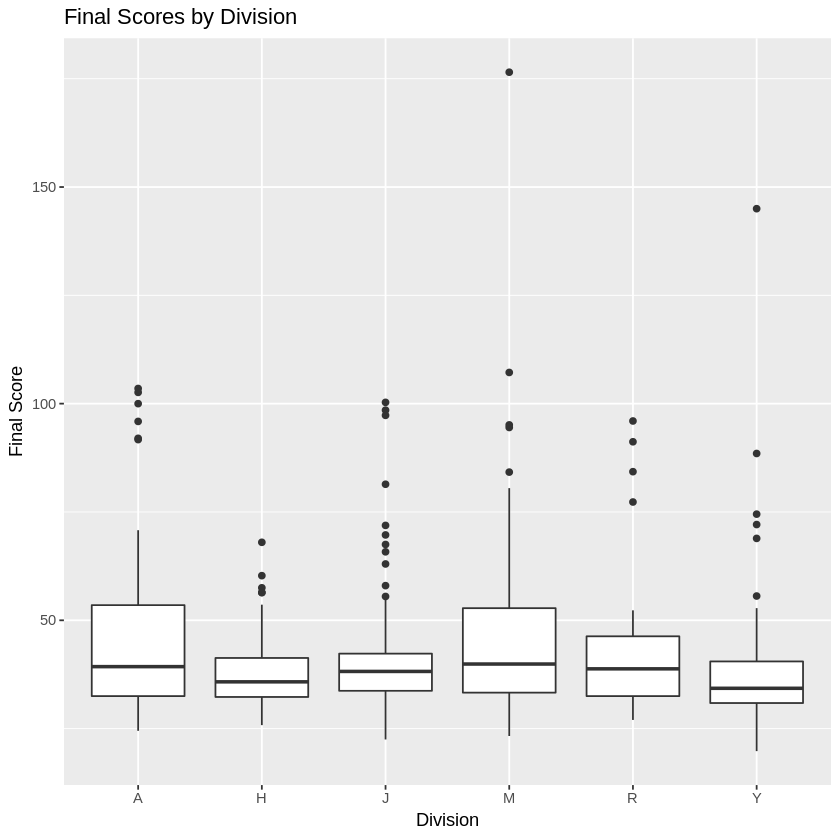

In [3]:
ggplot(scores, aes(x=Division, y=Total.after.SJ)) + geom_boxplot() +
    scale_y_continuous("Final Score") + 
    ggtitle("Final Scores by Division")

the `aov` command in r runs an ANOVA tests that can be used for further analysis.

In [4]:
#ANOVA
anovaResults = aov(Total.after.SJ ~ Division, data = scores)
summary(anovaResults)

             Df Sum Sq Mean Sq F value  Pr(>F)   
Division      5   5382  1076.5   3.644 0.00308 **
Residuals   416 122898   295.4                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

We can see that there is a F value of 3.644 and a p-value of 0.0308.  Since the p-value is less than 0.05, we can conclude that there is sufficient evidence that there is a difference in the means of the final scores of each division.  Therefore, we reject the null hypothesis and say that there is a statistically significant difference in final scores between divisions.

But which divisions?  There are 6 divisions to compare, so we will need to do some more analysis to see if we can determine which groups are different from each other.  We will run a pairwise t test to compare the p-values for each combination of divisions.

In [5]:
pairwise.t.test(scores$Total.after.SJ,scores$Division, p.adjust="bonferroni")


	Pairwise comparisons using t tests with pooled SD 

data:  scores$Total.after.SJ and scores$Division 

  A     H     J     M     R    
H 0.036 -     -     -     -    
J 1.000 1.000 -     -     -    
M 1.000 0.009 0.321 -     -    
R 1.000 1.000 1.000 1.000 -    
Y 0.261 1.000 1.000 0.080 1.000

P value adjustment method: bonferroni 

We can see that there are 3 p-values less than 0.05: the difference between Amateur and Horse, the difference between Master and Horse, and the difference between Master and Youth.

For further assurance that the results from the paired t-test are accurate, I also ran the Tukey test to compare the differences between the groups.

In [6]:
TukeyHSD(anovaResults, conf.level=0.95)

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = Total.after.SJ ~ Division, data = scores)

$Division
         diff        lwr        upr     p adj
H-A -8.708620 -16.866201 -0.5510396 0.0286105
J-A -4.791649 -12.252634  2.6693350 0.4419670
M-A  1.449351  -6.739803  9.6385047 0.9959091
R-A -3.541760 -12.775618  5.6920968 0.8820023
Y-A -6.972872 -15.332813  1.3870700 0.1627834
J-H  3.916971  -3.784500 11.6184417 0.6923895
M-H 10.157971   1.749130 18.5668120 0.0078392
R-H  5.166860  -4.262376 14.5960954 0.6196093
Y-H  1.735749  -6.839505 10.3110030 0.9923360
M-J  6.241000  -1.493906 13.9759061 0.1922564
R-J  1.249889  -7.583607 10.0833846 0.9985936
Y-J -2.181222 -10.096723  5.7342784 0.9693221
R-M -4.991111 -14.447675  4.4654529 0.6573231
Y-M -8.422222 -17.027517  0.1830730 0.0590744
Y-R -3.431111 -13.035953  6.1737305 0.9101995


In the results, we can see that the same 3 combinations show a p-value of less than 0.05.  While the values are not the same, they are within the same ballpark.

### Predict Final Total Score Given Dressage Score and Division

Now comes the really fun part: predicting scores and placings given an initial dressage score and a division.

The first step is to create a table of test data.  We specify the dressage score and the division the competitor is entered in.  This test data will be used to predict the final score and the probability of elimination.

In [21]:
testData <- data.frame(Dr.Score = c(32.5, 35.4, 42.0, 58.4, 19.9, 23.5, 21.6, 33.1), 
                       Division= c("A", "H", "M", "Y", "J", "H", "R", "A"))
testData

Dr.Score,Division
32.5,A
35.4,H
42.0,M
58.4,Y
19.9,J
23.5,H
21.6,R
33.1,A


Let's also create a test sample where the competitors have the same dressage score and are entered in different divisions.

In [22]:
sameDrScore <- data.frame(Dr.Score = rep_len(34.2, 6), 
                       Division= c("A", "H", "M", "Y", "J", "R"))
sameDrScore

Dr.Score,Division
34.2,A
34.2,H
34.2,M
34.2,Y
34.2,J
34.2,R


Now we can run the `predict` command to run the test data through the linear model we created above.

In [23]:
predictResults <- glm(Total.after.SJ ~ Division + Dr.Score, family=gaussian(link = "identity"), data = scores)
testData["Estimated Final Score"] <- predict(predictResults, testData, type="response")
testData

Dr.Score,Division,Estimated Final Score
32.5,A,44.84689
35.4,H,41.06583
42.0,M,58.72603
58.4,Y,73.80978
19.9,J,21.64032
23.5,H,25.20976
21.6,R,26.84327
33.1,A,45.64636


Just to see what happens, let's use the same dressage score and different divisions to see what the difference in estimation is.

In [24]:
sameDrScore["Estimated Final Score"] <- 
    predict(predictResults, sameDrScore, type="response")
sameDrScore

Dr.Score,Division,Estimated Final Score
34.2,A,47.11204
34.2,H,39.46690
34.2,M,48.33298
34.2,Y,41.56468
34.2,J,40.69424
34.2,R,43.63204


Given the above results, we can see that the highest estimated score is for the Master Division and the lowest predicted score is for the Horse Division.  This makes sense, given that the p-values from the Tukey and pairwise t tests are smallest for those two divisions.  The next highest score, Amateur, also had a low p-value for its difference with the Horse division.

## Comparison of Incompleted and Completed Scores

The scores of competitors who completed the event are not the only ones of interest.  It would be nice to know if we can predict whether or not a rider will be disqualified from a competition.


##### **H0**: There is no difference in the initial dressage score for competitors who were eliminated and those that were not.
##### **HA**: There is a difference in the initial dressage score for competitors who were eliminated and those that were not.


The first step is to add a new column to the datasets that says whether or not the competitor completed the competition.  Then, the incompleted scores are combined with the completed scores to yield a master table containing all the data points.

In [11]:
#add new columns
incompletedScores["Completed"] <- FALSE
scores["Completed"]<- TRUE
#combine scores into one table
total <- rbind(scores, incompletedScores)
head(total)

Dr.Score,Place.after.Dr,XC.Jump,XC.Time,Total.after.XC,Place.after.XC,SJ.Jump,SJ.Time,Total.after.SJ,Final.Place,Year,Division,Completed
24.5,1,0,0.0,24.5,1,0,0,24.5,1,2018,A,TRUE
28.1,4,0,0.4,28.5,2,0,0,28.5,2,2018,A,TRUE
30.5,6,0,0.0,30.5,4,0,0,30.5,3,2018,A,TRUE
31.1,8,0,0.0,31.1,6,0,0,31.1,4,2018,A,TRUE
32.0,11,0,0.0,32.0,8,0,0,32.0,5,2018,A,TRUE
32.5,13,0,0.0,32.5,10,0,0,32.5,6,2018,A,TRUE


Now that we've added the "Completed" field, let's group by that to see if we notice a difference between the two groups visually.

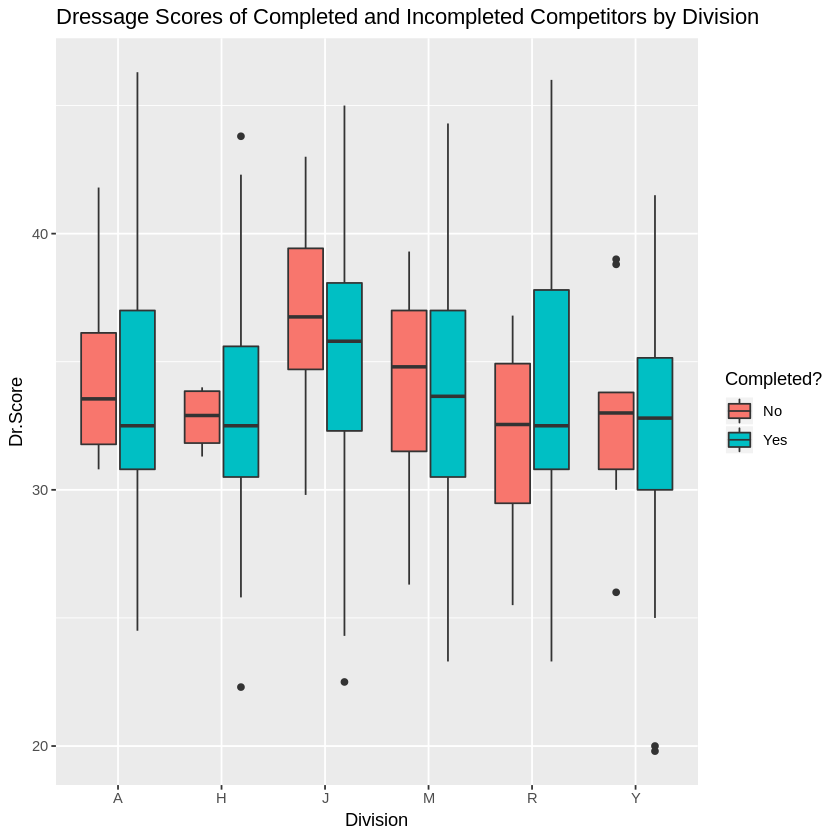

In [12]:
ggplot(total, aes(x=Division, y=Dr.Score, fill=Completed)) + 
        geom_boxplot() +
        ggtitle("Dressage Scores of Completed and Incompleted Competitors by Division") + 
        scale_fill_discrete(name="Completed?",
                           label=c("No", "Yes"))

While there are slight trends (notice that the median score of those who completed is always the same or lower than the scores of incompleted), the two groups appear fairly similar.  The final step is to perform a t test to see if there is a statistically significant difference between the two groups.

In [13]:
t.test(incompletedScores$Dr.Score, scores$Dr.Score, var.equal=FALSE)


	Welch Two Sample t-test

data:  incompletedScores$Dr.Score and scores$Dr.Score
t = 1.0278, df = 60.469, p-value = 0.3081
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.618503  1.926362
sample estimates:
mean of x mean of y 
 34.30417  33.65024 


We can see that there is a p-value of 0.3081.  Since it is greater than 0.05, we will fail to reject the null hypothesis that there is a difference in dressage scores between the two groups.

This means that there is no relationship between initial dressage score and being eliminated.

### Predict Probability of Elimination Given Division and Initial Dressage Score

Despite the fact that initial dressage score paired t test had a high p-value, we will still build a model that takes initial dressage score into account.  Otherwise, the results would just be the probability of each division. 

The first step towards being able to predict that a certain competitor will be eliminated is to convert the boolean values of `Completed` into numerical values.  We will convert `TRUE` to 1 and `FALSE` to 0.  Below we can see that the transformation has completed successfully.

In [14]:
total["Completed"] <- as.integer(as.logical(total$Completed))
head(total)

Dr.Score,Place.after.Dr,XC.Jump,XC.Time,Total.after.XC,Place.after.XC,SJ.Jump,SJ.Time,Total.after.SJ,Final.Place,Year,Division,Completed
24.5,1,0,0.0,24.5,1,0,0,24.5,1,2018,A,1
28.1,4,0,0.4,28.5,2,0,0,28.5,2,2018,A,1
30.5,6,0,0.0,30.5,4,0,0,30.5,3,2018,A,1
31.1,8,0,0.0,31.1,6,0,0,31.1,4,2018,A,1
32.0,11,0,0.0,32.0,8,0,0,32.0,5,2018,A,1
32.5,13,0,0.0,32.5,10,0,0,32.5,6,2018,A,1


In [ ]:
Next, generate the binomal linear 

In [15]:
elimModel <- glm(Completed ~ Dr.Score + Division, family=binomial(link="logit"), data=total)
summary(elimModel)


Call:
glm(formula = Completed ~ Dr.Score + Division, family = binomial(link = "logit"), 
    data = total)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.4312   0.3742   0.4522   0.5025   0.6340  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)   
(Intercept)  3.31937    1.25330   2.649  0.00808 **
Dr.Score    -0.03105    0.03498  -0.888  0.37473   
DivisionH    0.55448    0.63562   0.872  0.38302   
DivisionJ   -0.10342    0.48357  -0.214  0.83065   
DivisionM   -0.44142    0.49401  -0.894  0.37156   
DivisionR    0.14853    0.64104   0.232  0.81677   
DivisionY   -0.35340    0.51674  -0.684  0.49404   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 309.95  on 469  degrees of freedom
Residual deviance: 305.25  on 463  degrees of freedom
AIC: 319.25

Number of Fisher Scoring iterations: 5


Now, we can use the same test data sets as before to calculate the probability that each competitor will be eliminated.

In [16]:
testData["Probability of Being Eliminated"] <- 1 - predict(elimModel, testData, type="response")
testData

Dr.Score,Division,Estimated Final Score,Probability of Being Eliminated
32.5,A,44.84689,0.09027974
35.4,H,41.06583,0.05870891
42.0,M,58.72603,0.17167275
58.4,Y,73.80978,0.24001245
19.9,J,21.64032,0.06926465
23.5,H,25.20976,0.04132184
21.6,R,26.84327,0.05747518
33.1,A,45.64636,0.09182157


In [17]:
sameDrScore["Probability of Being Eliminated"] <- 1 - predict(elimModel, sameDrScore, type="response")
sameDrScore

Dr.Score,Division,Estimated Final Score,Probability of Being Eliminated
34.2,A,47.11204,0.09470982
34.2,H,39.46690,0.05668334
34.2,M,48.33298,0.13991289
34.2,Y,41.56468,0.12965213
34.2,J,40.69424,0.10395660
34.2,R,43.63204,0.08271857


It is interesting to note that although the p-value was larger than we normally consider statistically significant, the dressage score still had an effect on the probability.  For example, the first row shows an amateur competitor with different dressage scores.  We can see that the competitor with the higher dressage score has a slightly higher probability of being eliminated.

## Conclusion

To conclude, there were some relationships that did not prove to have statistically significant relationships, such as year and final score and initial dressage score and being eliminated.  There was a relationship between division and final score, showing that different divisions tend to score differently.